# Model match outcome
Try a variety of models: Logistic regression, Random Forest, xgboost. Outstanding question: Can we see how well our scores perform vs. using Betfair Starting Price scores? We'll need to download BSP data and treat it as a source of truth. It would also be good to analyse BSP probabilities for weaknesses, are there any types of match (strong favourite? certain countries? finals vs qualifying rounds?) that BSP predicts badly? (if the model does better - we could use it to guide snooker betting tips!)

In [1]:
!/home/ec2-user/anaconda3/envs/python3/bin/pip install xgboost

Looking in indexes: https://packages.dns.ad.zopa.com/artifactory/api/pypi/pypi-python2711-virtual/simple/
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### Imports and constants

In [2]:
import requests

import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


pd.options.display.max_columns = 500
plt.style.use('seaborn')

In [3]:
TARGET_COL = 'WIN'

NULL_IMPUTATION_VALUE = -99999

RANDOM_SEED = 12345

TRIPLE_CROWN_EVENTS = ['World Championship', 'UK Championship', 'Masters']

In [4]:
def calibration_plot(
    scores,
    target,
    n_bins=20
):
    binned_score = pd.qcut(scores, n_bins)
    bin_centres = sorted(pd.Series(scores).groupby(binned_score).mean().values)

    targets = target.groupby(binned_score).mean()

    score_qs = target.groupby(binned_score)\
                     .agg(['mean', 'sem'])\
                     .unstack()
    
    _, axis = plt.subplots(figsize=(10,6))
    
    # Plotting the line
    axis.plot(
        bin_centres,
        score_qs['mean'],
        color='blue'
    )
    
    # Plotting the standard error of the mean as different CI shades
    axis.fill_between(
        bin_centres, 
        score_qs['mean'] + score_qs['sem'], 
        score_qs['mean'] - score_qs['sem'],
        facecolor='blue', 
        alpha=2**1.5 / (3 ** 1.5)
    )
    axis.fill_between(
        bin_centres, 
        score_qs['mean'] + score_qs['sem'], 
        score_qs['mean'] + 2 * score_qs['sem'],
        facecolor='blue', 
        alpha=1**1.5 / (3 ** 1.5)
    )
    axis.fill_between(
        bin_centres, 
        score_qs['mean'] - score_qs['sem'], 
        score_qs['mean'] - 2 * score_qs['sem'],
        facecolor='blue', 
        alpha=1**1.5 / (3 ** 1.5)
    )

    axis.set_xlabel(scores.name)
    axis.set_ylabel(target.name)
    
    axis.plot(
        bin_centres, bin_centres, ls='--', color='black'
    )
    
    return axis

### Load and process data

In [5]:
players = pd.read_csv('data/Players_data.csv')
match_data = pd.read_csv('data/Raw_data.csv', low_memory=False)

In [6]:
match_data['TripleCrown'] = (match_data['Name'].isin(['World Championship', 'UK Championship', 'Masters'])).astype(int)
match_data['BestOf'] = match_data[['Score1', 'Score2']].max(axis=1)*2 - 1
match_data['CountryEqualsPlayer1Nationality'] = (match_data['Player1Nationality'] == match_data['Country']).astype(int)
match_data['CountryEqualsPlayer2Nationality'] = (match_data['Player2Nationality'] == match_data['Country']).astype(int)

In [7]:
match_data['delta_seeding'] = match_data['Player1Seeding'] - match_data['Player2Seeding']
match_data['delta_YearsAsPro'] = match_data['Player1YearsAsPro'] - match_data['Player2YearsAsPro']
match_data['delta_LastSeasonRank'] = match_data['Player1LastSeasonRank'] - match_data['Player2LastSeasonRank']
match_data['delta_LastSeasonSum'] = match_data['Player1LastSeasonSum'] - match_data['Player2LastSeasonSum']

In [8]:
FULL_FEATURE_LIST = [
    'Country',
    'Type_event',
    'NumCompetitors',
    'Stage',
    'TripleCrown',
    'BestOf',
    'Player1Nationality',
    'Player2Nationality',
    'CountryEqualsPlayer1Nationality',
    'CountryEqualsPlayer2Nationality',
    'Player1Seeding',
    'Player2Seeding',
    'Player1YearsAsPro',
    'Player2YearsAsPro',
    'Player1LastSeasonRank',
    'Player2LastSeasonRank',
    'Player1LastSeasonSum',
    'Player2LastSeasonSum',
    'delta_seeding',
    'delta_YearsAsPro',
    'delta_LastSeasonRank',
    'delta_LastSeasonSum'
]

In [9]:
PROCESSED_FEATURE_LIST = FULL_FEATURE_LIST

for feature in FULL_FEATURE_LIST:
    if pd.to_numeric(match_data.loc[~match_data[feature].isnull(), feature], errors='coerce').isnull().sum() > 0:
        print('{} is not numeric! Encoding as one-hot...'.format(feature))
        match_data = pd.get_dummies(match_data, columns=[feature], prefix=feature)
        PROCESSED_FEATURE_LIST = PROCESSED_FEATURE_LIST + \
            [col for col in match_data.columns if col.startswith('{}_'.format(feature))]
        PROCESSED_FEATURE_LIST.remove(feature)

Country is not numeric! Encoding as one-hot...
Type_event is not numeric! Encoding as one-hot...
Stage is not numeric! Encoding as one-hot...
Player1Nationality is not numeric! Encoding as one-hot...
Player2Nationality is not numeric! Encoding as one-hot...


In [10]:
match_data[PROCESSED_FEATURE_LIST] = match_data[PROCESSED_FEATURE_LIST].fillna(NULL_IMPUTATION_VALUE)

## Initial modelling - try out what model type works best
We'll optimise later. For now, let's decide what type of model we want to use.

Split the data so that our metrics can be based on test set data.

In [20]:
train, test = train_test_split(match_data, train_size=0.75, random_state=RANDOM_SEED)

## 1. Logistic Regression

In [21]:
lr = LogisticRegressionCV(cv=5, random_state=0)
lr.fit(train[PROCESSED_FEATURE_LIST], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': lr.predict_proba(test[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': lr.predict(test[PROCESSED_FEATURE_LIST]),
    'outcome': test[TARGET_COL].values
})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [22]:
model_df.head()

,probability_pred,outcome_pred,outcome
0,0.504345,1,1
1,0.779136,1,1
2,0.561689,1,0
3,0.812232,1,1
4,0.569225,1,1


How well calibrated are our model's probability estimates?

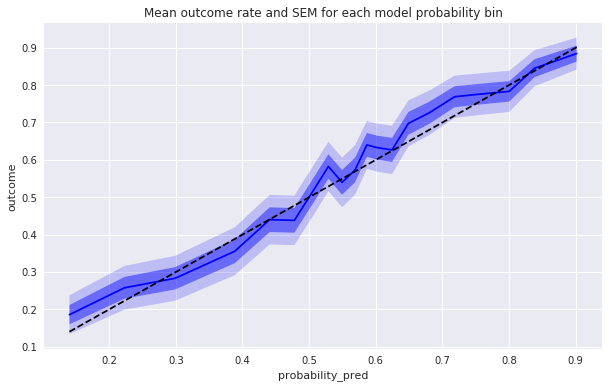

In [23]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

What is our accuracy?

In [24]:
pd.DataFrame(confusion_matrix(model_df['outcome'], model_df['outcome_pred'], normalize='true')).rename(
    columns={0: 'Predicted 0', 1: 'Predicted 1'},
    index={0: 'Outcome 0', 1: 'Outcome 1'}
)

,Predicted 0,Predicted 1
Outcome 0,0.489753,0.510247
Outcome 1,0.176967,0.823033


In [25]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6823425022182786


## 2. Random Forest

In [41]:
rf = RandomForestClassifier(
    n_estimators=75,
    max_features=20,
    max_depth=5,
    min_samples_leaf=0.001,
    random_state=RANDOM_SEED
)
rf.fit(train[PROCESSED_FEATURE_LIST], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': rf.predict_proba(test[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': rf.predict(test[PROCESSED_FEATURE_LIST]),
    'outcome': test[TARGET_COL].values
})

How well calibrated are the probability estimates?

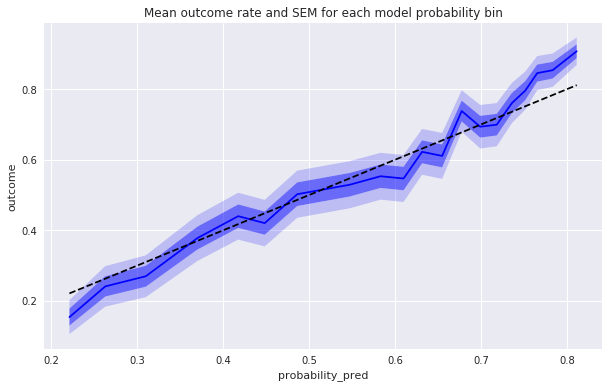

In [42]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

Accuracy?

In [43]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6876663708961845


## 2b. Hyperparameter optimisation on Random Forest

In [54]:
from sklearn.model_selection import GridSearchCV


rf = RandomForestClassifier(
    n_jobs=-1, 
    max_features='sqrt', 
    n_estimators=75,
    max_depth=5,
    min_samples_leaf=0.001
)

param_grid = { 
    'n_estimators': [50, 75, 100, 125],
    'max_depth': [5, 7, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [0.05, 0.01, 0.005, 0.001, 0.0005]
}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
CV_rf.fit(match_data[PROCESSED_FEATURE_LIST], match_data[TARGET_COL])
print(CV_rf.best_params_)

{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 0.0005, 'n_estimators': 75}


Let's use these parameters and retrain the RF.

In [80]:
rf = RandomForestClassifier(
    n_estimators=75,
    max_features='sqrt',
    max_depth=7,
    min_samples_leaf=0.0005,
    random_state=RANDOM_SEED
)
rf.fit(train[PROCESSED_FEATURE_LIST], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': rf.predict_proba(test[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': rf.predict(test[PROCESSED_FEATURE_LIST]),
    'outcome': test[TARGET_COL].values
})

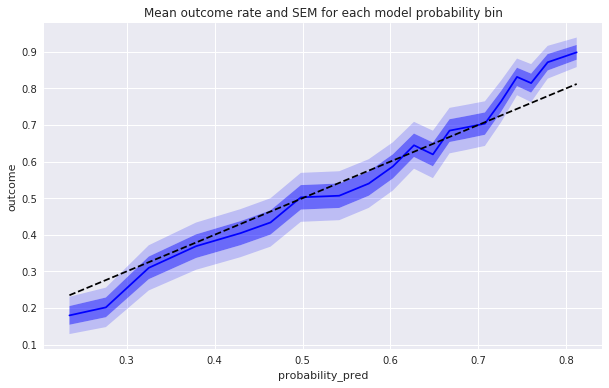

In [81]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

In [82]:
pd.DataFrame(confusion_matrix(model_df['outcome'], model_df['outcome_pred'], normalize='true')).rename(
    columns={0: 'Predicted 0', 1: 'Predicted 1'},
    index={0: 'Outcome 0', 1: 'Outcome 1'}
)

,Predicted 0,Predicted 1
Outcome 0,0.520757,0.479243
Outcome 1,0.188484,0.811516


In [83]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6887755102040817


## 3. xgboost

In [44]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=RANDOM_SEED)
xgb_model.fit(train[PROCESSED_FEATURE_LIST], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': xgb_model.predict_proba(test[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': xgb_model.predict(test[PROCESSED_FEATURE_LIST]),
    'outcome': test[TARGET_COL].values
})

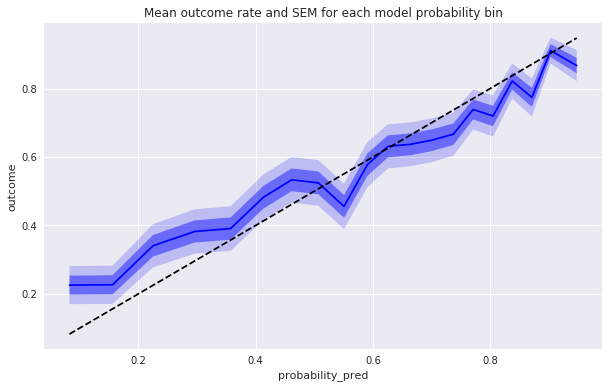

In [45]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

In [46]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6694764862466726


___Summary: Random Forest does the best so far. We can try more models and try to improve things if we really care about using this model to bet money.___

## How well does the random forest predict outcomes of particular subsets of matches?

Are there any types of match where the model performs particularly bad? Any that are particularly good?

In [58]:
subset = match_data.loc[
    match_data['TripleCrown'] == 1
]

0.7205


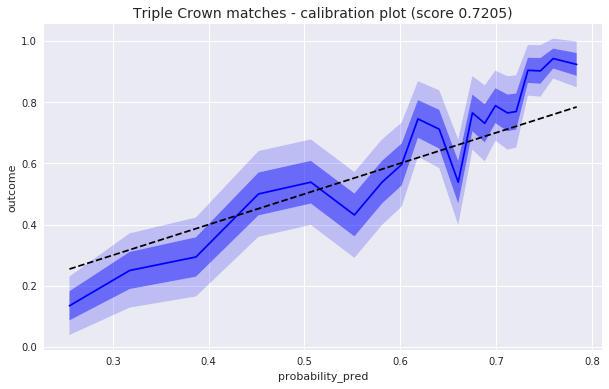

In [66]:
model_df = pd.DataFrame({
    'probability_pred': rf.predict_proba(subset[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': rf.predict(subset[PROCESSED_FEATURE_LIST]),
    'outcome': subset[TARGET_COL].values
})

accuracy = round(accuracy_score(model_df['outcome_pred'], model_df['outcome']), 4)
print(accuracy)

axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title(
    'Triple Crown matches - calibration plot (score {})'.format(accuracy), 
    fontsize=14
)
plt.show()

In [71]:
subset = match_data.loc[
    match_data['Country_China'] == 1
]

0.7009


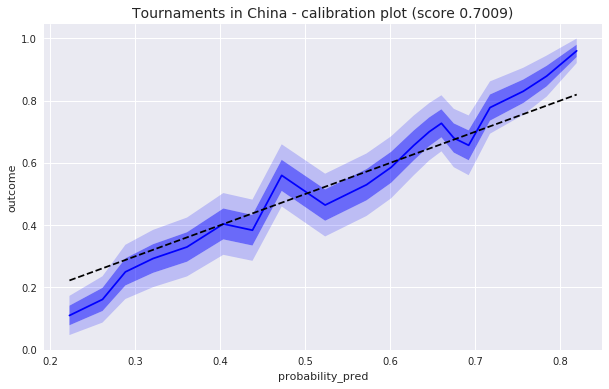

In [72]:
model_df = pd.DataFrame({
    'probability_pred': rf.predict_proba(subset[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': rf.predict(subset[PROCESSED_FEATURE_LIST]),
    'outcome': subset[TARGET_COL].values
})

accuracy = round(accuracy_score(model_df['outcome_pred'], model_df['outcome']), 4)
print(accuracy)

axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title(
    'Tournaments in China - calibration plot (score {})'.format(accuracy), 
    fontsize=14
)
plt.show()

In [75]:
subset = match_data.loc[
    match_data['Country_England'] == 1
]

0.6948


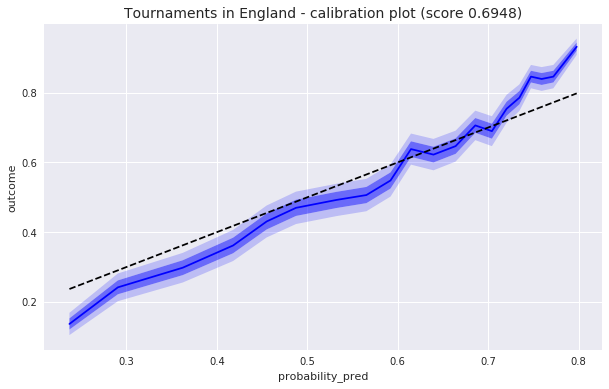

In [77]:
model_df = pd.DataFrame({
    'probability_pred': rf.predict_proba(subset[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': rf.predict(subset[PROCESSED_FEATURE_LIST]),
    'outcome': subset[TARGET_COL].values
})

accuracy = round(accuracy_score(model_df['outcome_pred'], model_df['outcome']), 4)
print(accuracy)

axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title(
    'Tournaments in England - calibration plot (score {})'.format(accuracy), 
    fontsize=14
)
plt.show()